## Parallel programming with Python's multiprocessing library

Here you will learn how to write programs that perform
several tasks in parallel using Python's built-in <a href="https://docs.python.org/3/library/multiprocessing.html" target="_blank">multiprocessing</a> library. Please 
consult <a href="https://docs.python.org/3/library/multiprocessing.html"
target="_blank">documentation</a> to learn more, or to answer any
detailed questions as we will only cover a small subset of the
library's functionality. Most of the material here is taken from [this tutorial](http://localhost:8888/?token=48ec7adcec6bfaaa914d17f70e47b9f8bd67f8cac78f4052)


Parallelism (aka parallel programming) is when two or more tasks run at the same time. There's important terminology to understand regarding parallelism too.

A **thread** is an execution context for code.

A **process** is a program and state of all threads executing in a program.

One process can have several threads running at the same time. One program could also have several proccesses running at the same time.

In Python, by default programs run as a single process with a single thread of execution; this uses just a single CPU.

Examples parallelism can help with:

  *  executing database queries
  *  pre-processing lots of images to use for machine learning
  *  web crawling

## Parallel programming models

Parallel programming has been important to scientific computing for
decades as a way to decrease program run times, making more complex
analyses possible (e.g. climate modeling, gene sequencing,
pharmaceutical development, aircraft design).

One of the motivations for parallel programming has been the
diminishing marginal increases in single CPU performance with each new
generation of CPU (see <a href="http://www.gotw.ca/publications/concurrency-ddj.htm"
target="_blank">The Free Lunch is over</a>).  In response, computer
makers have introduced multi-core processors that contain more than
one processing core.  It's not uncommon for desktop, laptop, and even
tablets and smart phones to have two or more CPU cores.

In [1]:
import multiprocessing

multiprocessing.cpu_count()

8

### GPU and heterogeneous computing

In addition to multi-core CPUs, **Graphics Processing Units (GPU)** have
become more powerful recently (often having hundreds of parallel
execution units). GPUs are increasingly being use not just for drawing
graphics to the screen, but for general purpose computation.  GPUs can
even be used in conjunction with CPUs to boost parallel computing
performance (this is known as *heterogeneous computing*).  GPUs are best
*suited to applying the same computation over arrays of data*, while
*CPUs are better suited to algorithms that include conditional branches
of execution* (e.g. different paths through the code based on if
statements). Emerging tools, such as <a href="http://en.wikipedia.org/wiki/OpenCL" target="_blank">OpenCL</a>
help coordinate parallel execution across heterogeneous computer
platforms that contain differing CPU and GPU resources.

### CPU multi-processing / Distributed-memory parallelism

Unfortunately, most computer programs cannot take advantage of
performance increases offered by GPUs or multi-core CPUs unless we
modify these programs.  In this lesson we will develop an example
program that uses the Python multiprocessing library to simultaneously
execute tasks on a multi-core CPU, decreasing the overall program run
time.

Multi-processing is one way to execute tasks in parallel on a
multi-core CPU, or across multiple computers in a computing cluster.
In multi-processing, each task runs in its own process; each program
running on your computer is represented by one or more processes. For
example, if you are running a web browser, a text editor, and an
e-mail client, you are running at least three processes (and likely
many more background processes). On modern operating systems, each
process gets its own portion of your computer's memory, ensuring that
no process can interfere with the execution of another (though tools
like <a href="http://en.wikipedia.org/wiki/Message_Passing_Interface"
target="_blank">MPI</a> and even Python's multiprocessing library can
be used to share data between processes running locally or in
distributed computing environments).

### CPU multi-threading (shared memory parallelism)

Multi-processing is not to be confused with multi-threading, or
shared-memory parallelism. In modern operating systems, each process
contains one or more threads of execution.  These threads share the
same portion of memory assigned to their parent process; each thread
can run in parallel if the computer has more than one CPU core. For
certain algorithms, multi-threading can be more efficient than
multi-processing (though multi-processing solutions such as MPI often
scale better to larger problem sizes).  However, multi-threading is
more error-prone to program and is generally only done directly by
expert systems programmers.  Tools such as <a href="http://openmp.org/" target="_blank">OpenMP</a> should in general
be used for multi-threading in scientific computing.


## Python's Global Interpreter Lock

CPython (the standard python implementation) has something called the GIL (Global Interpreter Lock); the GIL prevents two threads from executing simultaneously in the same program. However, two threads can run concurrently and one can run code while another may be waiting.

The GIL limits parallel programming in Python out of the box.





# `map` Function and Example

The use of `map` will be applied in our parallel programming examples later so we look at this a bit.

Below we will see a function called `number_times_two` to take in a number, multiply it by two and return the result.

`map` is a built-in Python function that helps us easily apply a function over every item in an iterable such as a list.

We'll use the `map` function to apply `number_times_two` to every element in the list of numbers [1, 2, 3, 4].

In [2]:
def number_times_two(number):
    """
    Multiply a number by 2
    
    :param number: a value we'll use in our computation
    :type number: (preferably an) int
    
    :returns: number*2
    """
    return number*2

In [3]:
type(number_times_two)

function

The `map` function returns an map object that is an iterator.

In [3]:
map(number_times_two, [1, 2, 3, 4])

We can call the built-in `list` function to output our result, the `map` object, as a list.

In [4]:
list(map(number_times_two, [1, 2, 3, 4]))

[2, 4, 6, 8]

# Parallelism

In [5]:
from requests import get
from multiprocessing.dummy import Pool as ThreadPool 
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from time import time
from random import sample
import numpy as np
%matplotlib inline

We use some functions for visualizing the different techniques

In [6]:
def multithreading(function, iterable, number_of_threads):
    """
    Maps a function across an iterable (such as a list of elements) with the optional use of multithreading.
    
    :param function: name of a function
    :type function: function
    
    :param iterable: elements used as inputs to function parameter
    :type iterable: list
    
    :param number_of_threads: number of threads to use in map operation
    :type number_of_threads: int
    
    :returns list_objects: return objects from our function parameter calls
    :return type: list
    """    
    with ThreadPoolExecutor(max_workers=number_of_threads) as executor:
        responses = executor.map(function, iterable)
    return list(responses)


In [7]:
def do_multiprocessing(function, iterable, number_of_concurrent_processes):
    """
    Maps a function across an iterable (such as a list of elements) with the optional use of multiprocessing.
    
    :param function: name of a function
    :type function: function
    
    :param iterable: elements used as inputs to function parameter
    :type iterable: list
    
    :param number_of_concurrent_processes: number of concurrent processes in multiprocessing
    :type number_of_concurrent_processes: int
    
    :returns list_objects: return objects from our function parameter calls
    :return type: list
    """    
    with ProcessPoolExecutor(max_workers=number_of_concurrent_processes) as executor:
        responses = executor.map(function, iterable)
    return list(responses)

In [8]:
def transform_timestamps_to_be_seconds_from_process_start_time(process_start_time, all_task_timestamps):
    """
    Take list of start and end timestamps of # of seconds since epoch, and subtract the process start time from them all
    
    Therefore we'll know how far timestamps are from the 0th second, the start of the program.
    
    :param process_start_time: # of seconds since epoch for start of task
    :type process_start_time: float
    
    :param all_task_timestamps: # of seconds since epoch for end of task
    :type all_task_timestamps: list
    
    :return function_timestamps_starting_from_zero: same shape as all_task_timestamps but all values subtracted by process_start_time
    :type function_timestamps_starting_from_zero: numpy array
    """
    function_timestamps_starting_from_zero = np.array(all_task_timestamps) - process_start_time
    return function_timestamps_starting_from_zero

In [9]:
def separate_list_elements(list_of_lists):
    """
    Given a list structure such as [[x, y], [x, y]] return a list of just the x's and another of just y's
    
    :param list_of_lists: list with nested lists
    :type list_of_list: list
    
    :return start_values, end_values: two lists - one of all 0-th index values and another of 1st index values in each nested list
    :return type: tuple storing two lists
    """
    start_values = [inner_list[0] for inner_list in list_of_lists]
    start_values = np.array(start_values)
    
    end_values = [inner_list[1] for inner_list in list_of_lists]
    end_values = np.array(end_values)
    return start_values, end_values

In [10]:
def generate_bar_colors(number_of_threads_or_subprocesses):
    """
    Make a list of colors the same length as the number of threads or number of concurrent subprocesses
    
    :param number_of_threads_or_subprocesses: number of threads used in multithreading or number of processes used in multiprocessing
    :type number_of_threads_or_subprocesses: int
    
    :return colors: list of colors chosen from good_colors
    :type colors: list
    """
    good_colors = ['firebrick', 'darkgreen', 'royalblue', 'rebeccapurple', 'dimgrey', 'teal', 'chocolate', 'darkgoldenrod']
    colors = sample(good_colors, number_of_threads_or_subprocesses)
    return colors



In [11]:
def visualize_task_times(start_times, end_times, plot_title, colors):
    """
    Use Matplotlib module to create a horizontal bar chart of the time elapsed for each task.
    
    :param start_times: start times of tasks
    :type start_times: list
    
    :param end_times: end times of tasks
    :type end_times: list
    
    :param plot_title: title of plot
    :type plot_title: string
    
    :param colors: colors of bars
    :type colors: list
    
    :return: None
    """
    plt.barh(range(len(start_times)), end_times-start_times, left=start_times, color=colors);
    plt.grid(axis='x');
    plt.ylabel("Tasks");
    plt.xlabel("Seconds");
    plt.title(plot_title);
    plt.figure(figsize=(12, 10));
    plt.show();
    return None;


In [12]:
def visualize_multiprocessing_effect(number_of_concurrent_processes, function_name, iterable, plot_title):
    """
    Perform multithreading given a function_name and number_of_threads and visualize tasks as bar chart
    
    :param number_of_concurrent_processes: number of concurrent processes in multiprocessing
    :type number_of_concurrent_processes: int
    
    :param function_name: name of function applied in multithreading operation
    :type function_name: function
    
    :param iterable: elements used as inputs to function parameter
    :type iterable: list
    
    :param plot_title: title of plot
    :type plot_title: string
    
    :return: None
    """
    process_start_time = time() # we track time here 
    time_logs_multiprocessing_op = do_multiprocessing(function_name, iterable, number_of_concurrent_processes)
    multiprocessing_task_timestamps = transform_timestamps_to_be_seconds_from_process_start_time(process_start_time, time_logs_multiprocessing_op)
    start_times, end_times = separate_list_elements(multiprocessing_task_timestamps)
    colors = generate_bar_colors(number_of_concurrent_processes)
    visualize_task_times(start_times, end_times, plot_title, colors)

In [13]:
def visualize_multithreading_effect(number_of_threads, function_name, iterable, plot_title):
    """
    Perform multithreading given a function_name and number_of_threads and visualize tasks as bar chart
    
    :param number_of_threads: number of threads used in multithreading
    :type number_of_threads: int
    
    :param function_name: name of function applied in multithreading operation
    :type function_name: function
    
    :param iterable: elements used as inputs to function parameter
    :type iterable: list
    
    :param plot_title: title of plot
    :type plot_title: string
    
    :return: None
    """
    process_start_time = time() # we track time here 
    time_logs_multithreading_op = multithreading(function_name, iterable, number_of_threads)
    multithreading_task_timestamps = transform_timestamps_to_be_seconds_from_process_start_time(process_start_time, time_logs_multithreading_op)
    start_times, end_times = separate_list_elements(multithreading_task_timestamps)
    colors = generate_bar_colors(number_of_threads)
    visualize_task_times(start_times, end_times, plot_title, colors)



# Measure Server Response Times

This is a popular example on the web. For a list of URLs, we'll use the requests module to get a `response object`.

With this `response object`, we could later perform operations to see the status of the request, get the contents of the site and more!


In [14]:
twelve_urls = ['https://tu-chemnitz.de']*12
twelve_urls

['https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de',
 'https://tu-chemnitz.de']

In [16]:
def get_response_time_measurements(url):
    """
    mark start time, then call the get method and pass in a url to receive a server response object, then mark end time
    
    :param url: address of a worldwide web page 
    :type url: string
    
    :returns: start_time and stop_time of this task
    :type returns: list
    """
    start_time = time()
    try:
        response = get(url)
    except Exception as exception_object:
        print('Error with request for url: {0}'.format(url))
    stop_time = time()
    return [start_time, stop_time]

In [17]:
multithreading(function=get_response_time_measurements, iterable=twelve_urls, number_of_threads=1)

[[1593852054.6060383, 1593852054.943841],
 [1593852054.943841, 1593852055.246668],
 [1593852055.2476676, 1593852055.5474944],
 [1593852055.5474944, 1593852055.8413253],
 [1593852055.8413253, 1593852056.1381543],
 [1593852056.1381543, 1593852056.436982],
 [1593852056.436982, 1593852056.738806],
 [1593852056.738806, 1593852057.0436313],
 [1593852057.0436313, 1593852057.351453],
 [1593852057.351453, 1593852057.6562831],
 [1593852057.6562831, 1593852057.962103],
 [1593852057.962103, 1593852058.2609308]]

# Multithreading

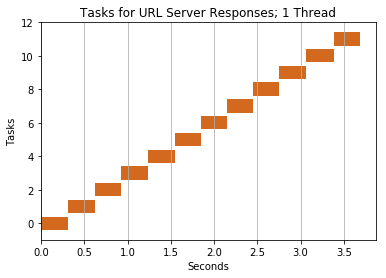

<Figure size 864x720 with 0 Axes>

In [18]:
visualize_multithreading_effect(number_of_threads=1,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 1 Thread")

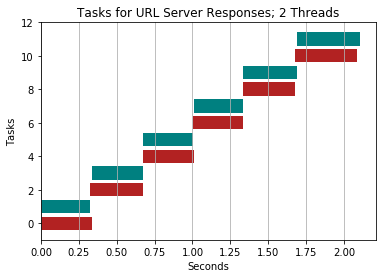

<Figure size 864x720 with 0 Axes>

In [19]:
visualize_multithreading_effect(number_of_threads=2,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 2 Threads")

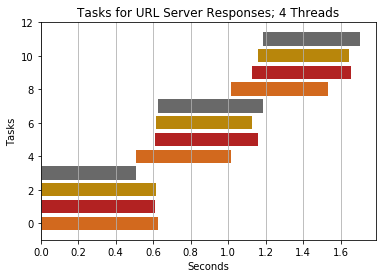

<Figure size 864x720 with 0 Axes>

In [20]:
visualize_multithreading_effect(number_of_threads=4,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 4 Threads")

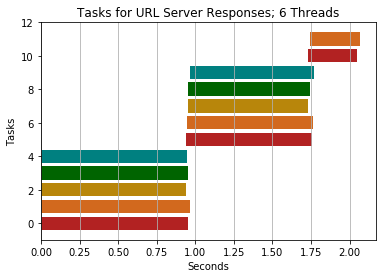

<Figure size 864x720 with 0 Axes>

In [25]:
visualize_multithreading_effect(number_of_threads=5,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 6 Threads")

# Multiprocessing

In [26]:
visualize_multiprocessing_effect(number_of_concurrent_processes=1,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 1 Process")

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [23]:
visualize_multiprocessing_effect(number_of_concurrent_processes=2,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 2 Processes")


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [24]:
visualize_multiprocessing_effect(number_of_concurrent_processes=3,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 3 Process")


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

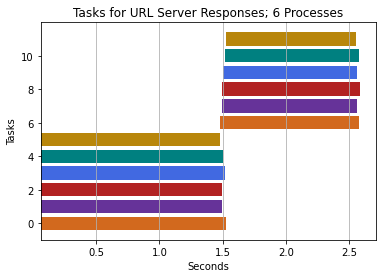

<Figure size 864x720 with 0 Axes>

In [32]:
visualize_multiprocessing_effect(number_of_concurrent_processes=6,
                                function_name=get_response_time_measurements,
                                iterable=twelve_urls,
                                plot_title="Tasks for URL Server Responses; 6 Processes")


# Single Process and Thread

Now, let's perform the same operation without the overhead of setting up multithreading.


In [33]:
%%time

# traditional python program without multithreading
task_timestamps = list(map(get_response_time_measurements, twelve_urls));

CPU times: user 518 ms, sys: 35.9 ms, total: 554 ms
Wall time: 11.2 s


**Conclusion:** both multithreading and multiprocessing complete much quicker than a single thread & program.

The reason parallel programming is much faster here is because the processor isn't working very hard to retreive the contents on the sites; however, the bottleneck is waiting for the site's server response to our HTTP request - an external resource. While one task is performing an operation of getting/waiting for a server response for one URL, another task can start for a different URL.

Threads are also fairly quick to combine their results too. So if we were web crawling and constantly wanted to combine results from multiple crawlers, it'd be ideal to use multiple threads to spawn multiple web crawlers rather than multiple processes which take longer to combine results.

# Example: Squares of Numbers

Given this big list of numbers in `big_list`, we want to output a new list that has the square of all numbers in `big_list`.

Think of this as a lot of small operations.


In [35]:
big_list = range(1, 12000000)

In [36]:
def square_value(x):
    return x**2

# Multithreading

Below we utilize code from another module of the Python standard library, multiprocessing, to perform multithreading for this operation.

By default, we will use all available threads on our computer.

In [37]:
%%time

pool = ThreadPool() 

squares_pool_results = pool.map(square_value, big_list)

pool.close()
pool.join()

CPU times: user 7.92 s, sys: 601 ms, total: 8.52 s
Wall time: 8.35 s


# Multiprocessing

Below we utilize code from the lower-level module of the Python standard library, multiprocessing, to perform multiprocessing for this operation.

We'll use 2 concurrent processes.


In [38]:
%%time

with Pool(processes=2) as multiprocessing_operation:
    multiprocessing_operation.map(square_value, big_list)


CPU times: user 1.65 s, sys: 654 ms, total: 2.31 s
Wall time: 3.53 s


# Single Process & Thread

In [39]:
%%time
    
squares_results = map(square_value, big_list)

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 24.1 µs


**Conclusion:** process completes much faster without parallel programming.

This may come as a surprise that parallel programming hurts our performance here.

Using parallel programming in Python or any other interpreted language with a global interpreter lock (GIL) can actually result in reduced performance if you're just doing a CPU bound task. This program must carry parallel programming's additional overhead of creating new threads or processes and synchronizing their results.


# Example: CPU Heavy Computations

In this example, we'll only perform 8 tasks - with each task requiring a large amount of operations.


In [40]:
def sum_all_intgers_from_zero_to_end_range_number(end_range_number):
    """
    Calculate the sum of all integer numbers from 0 to end_range_number. 
    
    :param end_range_number: highest value to loop over
    :type end_range_number: integer
    
    :returns [start_time, stop_time]: list of start_time of task and end time of task
    :return type: list
    """
    start_time = time()
    the_sum = 0
    for number in range(0, end_range_number):
        the_sum += number
    stop_time = time()
    return [start_time, stop_time]

In [41]:
large_number = 11**7
iterations = 8

In [43]:
large_numbers = [large_number]*iterations
large_numbers

[19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171]

In [44]:
large_numbers

[19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171,
 19487171]

# Multithreading

Let's visualize the effect of multithreading with 2 concurrent threads.


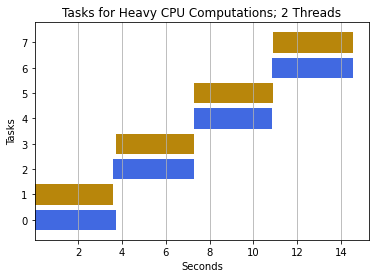

<Figure size 864x720 with 0 Axes>

In [44]:
visualize_multithreading_effect(number_of_threads=2,
                                function_name=sum_all_intgers_from_zero_to_end_range_number,
                                iterable=large_numbers,
                                plot_title="Tasks for Heavy CPU Computations; 2 Threads")

# Multiprocessing

Let's visualize the effect of multiprocessing with 2 concurrent subprocesses.


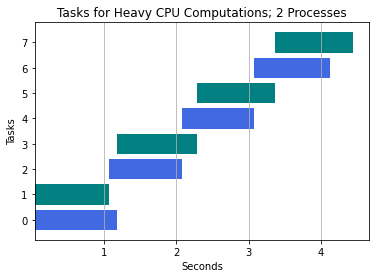

<Figure size 864x720 with 0 Axes>

In [45]:
visualize_multiprocessing_effect(number_of_concurrent_processes=2,
                                function_name=sum_all_intgers_from_zero_to_end_range_number,
                                iterable=large_numbers,
                                plot_title="Tasks for Heavy CPU Computations; 2 Processes")

Let's visualize the effect of multiprocessing with 4 concurrent subprocesses.

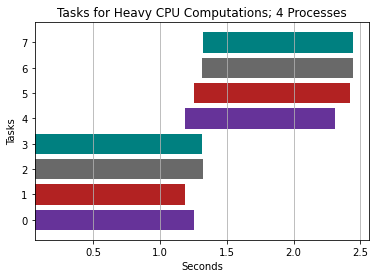

<Figure size 864x720 with 0 Axes>

In [46]:
visualize_multiprocessing_effect(number_of_concurrent_processes=4,
                                function_name=sum_all_intgers_from_zero_to_end_range_number,
                                iterable=large_numbers,
                                plot_title="Tasks for Heavy CPU Computations; 4 Processes")

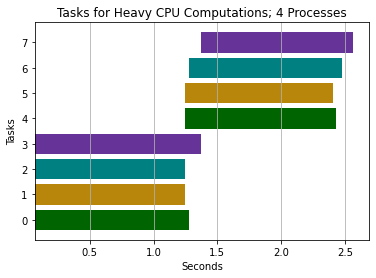

<Figure size 864x720 with 0 Axes>

In [50]:
visualize_multiprocessing_effect(number_of_concurrent_processes=4,
                                function_name=sum_all_intgers_from_zero_to_end_range_number,
                                iterable=large_numbers,
                                plot_title="Tasks for Heavy CPU Computations; 4 Processes")

# Single Program & Thread

In [51]:
%%time

for i in range(iterations):
    sum_all_intgers_from_zero_to_end_range_number(large_number)

CPU times: user 7.81 s, sys: 0 ns, total: 7.81 s
Wall time: 7.82 s


**Conclusion:** program completes much faster with multiprocessing at approximately 4 subprocesses running concurrently.

Multiprocessing here was helpful for this CPU intensive task because we could benefit from using multiple cores and avoid the global interpreter lock.

Interestingly, spinning up additional subprocesses past 4 has no major effect on improving runtime of our program. Notice how the total program runtime with 4 subprocesses is equivalent to the program with 5 subprocesses.

Threads provide no benefit in Python for CPU intensive tasks like these because of the global interpreter lock.


**Summary:**

The `threading` module uses `threads`, the `multiprocessing` module uses `processes`. The difference is that threads run in the **same memory space**, while processes have **separate memory**. This makes it a bit harder to share objects between processes with multiprocessing. Since threads use the same memory, precautions have to be taken or two threads will write to the same memory at the same time. This is what the global interpreter lock is for.